<a href="https://www.kaggle.com/code/daniyalatta/fake-real-prediction-lgbm-deberta?scriptVersionId=260055684" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### 🚀 Your upvote can motivate me to share more useful notebooks!¶
Let see I counting on You¶

<div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background-color: #f8f9fa; border-radius: 8px; border: 1px solid #e2e6ea; color: #343a40;">
    <h1 style="color: #007bff; font-weight: 700; border-bottom: 2px solid #007bff; padding-bottom: 10px; margin-bottom: 10px;">
        🏆 Fake or Real: End-to-End Text Classification
    </h1>
    <h3 style="color: #5a6268; font-weight: 500; margin-top: 0;">
        Competition-ready pipeline to classify text pairs as real or fake using advanced ML and deep learning techniques.
    </h3>

<div style="margin-top: 20px; font-size: 14px;">
    <strong>Author:</strong> Daniyal Atta<br>
    <strong>Date:</strong> August 22, 2025<br>
    <strong>Dataset:</strong> Fake or Real: The Impostor Hunt in Texts
</div>

<hr style="border-top: 1px dashed #ced4da; margin: 25px 0;">

<div style="font-size: 16px;">
    <h4 style="color: #007bff; margin-top: 0;">Notebook Overview</h4>
    <ol padding-left: 0;">
        <li style="margin-bottom: 8px;"><b>Data Augmentation:</b> Expand training data by swapping text pairs and flipping labels to improve model generalization.</li>
        <li style="margin-bottom: 8px;"><b>Dual-Pillar Modeling:</b> 
            <ul>
                <li><b>Feature Engineering Hammer (LightGBM):</b> Multi-level, high-dimensional features including stylistics, readability, semantic similarity, and text complexity (Perplexity).</li>
                <li><b>Deep Learning Blade (Siamese DeBERTa):</b> Siamese network with <code>DeBERTa-v3</code> backbone to capture deep semantic differences between text pairs.</li>
            </ul>
        </li>
        <li style="margin-bottom: 8px;"><b>Multi-Level Model Ensembling:</b> 
            <ul>
                <li><b>Level 1 (Blending):</b> Weighted fusion of LightGBM and DeBERTa predictions.</li>
                <li><b>Level 2 (Stacking):</b> Meta-model trained on Level 1 predictions for final output.</li>
            </ul>
        </li>
        <li style="margin-bottom: 8px;"><b>Cascaded Inference:</b> Fast LightGBM processes high-confidence "easy" samples first; complex ensemble handles "hard" samples for better accuracy.</li>
        <li style="margin-bottom: 8px;"><b>Exploratory Analysis & Visualization:</b> Feature importance, prediction distribution, error analysis, and model performance comparison with advanced plots.</li>
        <li style="margin-bottom: 0;"><b>Conclusion:</b> Summarize insights, key features, and deployment possibilities for real vs fake text classification tasks.</li>
    </ol>
</div>
</div>


![](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F14134958%2F6175ef9a195db59812751b9ca9f140c8%2FMulticlass-Text-Classification-Model.webp?generation=1757039424846090&alt=media)

In [1]:
# One-cell fix for widget display errors
!pip install -q ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension install --py widgetsnbextension --sys-prefix

# For JupyterLab, ensure the lab manager is installed
!jupyter labextension install @jupyter-widgets/jupyterlab-manager --no-build

# Restart the kernel (user will need to do this manually)
print("✅ ipywidgets installed and extensions enabled. Please restart the kernel to apply changes.")


Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Installing /usr/local/lib/python3.11/dist-packages/widgetsnbextension/static -> jupyter-js-widgets
Making directory: /usr/share/jupyter/nbextensions/jupyter-js-widgets/
Copying: /usr/local/lib/python3.11/dist-packages/widgetsnbextension/static/extension.js.LICENSE.txt -> /usr/share/jupyter/nbextensions/jupyter-js-widgets/extension.js.LICENSE.txt
Copying: /usr/local/lib/python3.11/dist-packages/widgetsnbextension/static/extension.js -> /usr/share/jupyter/nbextensions/jupyter-js-widgets/extension.js
Copying: /usr/local/lib/python3.11/dist-packages/widgetsnbextension/static/extension.js.map -> /usr/share/jupyter/nbextensions/jupyter-js-widgets/extension.js.map
- Validating: OK

    To i

<div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background-color: #f8f9fa; border-radius: 8px; border: 1px solid #e2e6ea; color: #343a40;">
    <h2 style="color: #007bff; font-weight: 700; border-bottom: 2px solid #007bff; padding-bottom: 10px; margin-bottom: 10px;">
        1. Environment Setup & Library Imports
    </h2>
   
</div>


In [2]:
!pip install tqdm textstat langdetect lightgbm scikit-learn transformers sentence-transformers accelerate wordcloud -q
import numpy as np
import pandas as pd
import os
import glob
import gc
import warnings
import re
import unicodedata
from tqdm.auto import tqdm
import textstat
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from langdetect import detect, DetectorFactory, LangDetectException
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch.cuda.amp as amp
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords', quiet=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 40.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.6 MB/s eta 0:00:00

2025-09-05 02:43:15.011497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757040195.202867      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757040195.262143      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background-color: #f8f9fa; border-radius: 8px; border: 1px solid #e2e6ea; color: #343a40;">
    <h2 style="color: #007bff; font-weight: 700; border-bottom: 2px solid #007bff; padding-bottom: 10px; margin-bottom: 10px;">
        2. Configuration Parameters
    </h2>


</div>


In [3]:
class CFG:
    seed = 42
    n_folds = 5
    target_col = 'label'
    data_path = '/kaggle/input/fake-or-real-the-impostor-hunt/data/'
    train_path = os.path.join(data_path, 'train')
    test_path = os.path.join(data_path, 'test')
    train_csv_path = os.path.join(data_path, 'train.csv')
    output_path = './'
    model_name = 'microsoft/deberta-v3-base'
    max_length = 512
    batch_size = 4
    n_epochs = 5
    learning_rate = 2e-5
    weight_decay = 0.01
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': 3000,
        'learning_rate': 0.03,
        'num_leaves': 35,
        'max_depth': 9,
        'seed': seed,
        'n_jobs': -1,
        'verbose': -1,
        'device': 'gpu',
        'colsample_bytree': 0.7,
        'subsample': 0.7,
    }
    cascaded_confidence_threshold = 0.45

def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    DetectorFactory.seed = seed

seed_everything(CFG.seed)
stop_words = set(stopwords.words("english"))

<div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background-color: #f8f9fa; border-radius: 8px; border: 1px solid #e2e6ea; color: #343a40;">
    <h2 style="color: #007bff; font-weight: 700; border-bottom: 2px solid #007bff; padding-bottom: 10px; margin-bottom: 10px;">
        3. Data Loading, Preprocessing & Augmentation
    </h2>


</div>


In [4]:
def read_text_files(df, base_path):
    texts_1, texts_2 = [], []
    all_dirs = glob.glob(os.path.join(base_path, 'article_*'))
    dir_map = {int(os.path.basename(p).replace('article_', '')): p for p in all_dirs}
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Reading Files From {os.path.basename(base_path)}"):
        article_id = row['id']
        dir_path = dir_map.get(article_id)
        text1_content, text2_content = "", ""
        if dir_path:
            try:
                with open(os.path.join(dir_path, 'file_1.txt'), 'r', encoding='utf-8') as f:
                    text1_content = f.read()
            except FileNotFoundError:
                pass
            try:
                with open(os.path.join(dir_path, 'file_2.txt'), 'r', encoding='utf-8') as f:
                    text2_content = f.read()
            except FileNotFoundError:
                pass
        texts_1.append(text1_content)
        texts_2.append(text2_content)
    df['text_1'] = texts_1
    df['text_2'] = texts_2
    return df

def load_data(config):
    train_df = pd.read_csv(config.train_csv_path)
    train_df = read_text_files(train_df, config.train_path)
    test_dirs = glob.glob(os.path.join(config.test_path, 'article_*'))
    test_ids = [int(os.path.basename(p).replace('article_', '')) for p in test_dirs]
    test_df = pd.DataFrame(sorted(test_ids), columns=['id'])
    test_df = read_text_files(test_df, config.test_path)
    train_df[config.target_col] = train_df['real_text_id'].apply(lambda x: 0 if x == 1 else 1)
    print(f"Original Training Data: {train_df.shape}")
    print(f"Test Data: {test_df.shape}")
    return train_df, test_df

train_df, test_df = load_data(CFG)

print("Perform data augmentation...")
df_swap = train_df.copy()
df_swap['text_1'], df_swap['text_2'] = df_swap['text_2'], df_swap['text_1']
df_swap['label'] = 1 - df_swap['label']
train_df_augmented = pd.concat((train_df, df_swap), axis=0).reset_index(drop=True)
print(f"Enhanced Training Data: {train_df_augmented.shape}")

Reading Files From train:   0%|          | 0/95 [00:00<?, ?it/s]

Reading Files From test:   0%|          | 0/1068 [00:00<?, ?it/s]

Original Training Data: (95, 5)
Test Data: (1068, 3)
Perform data augmentation...
Enhanced Training Data: (190, 5)


<div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background-color: #f8f9fa; border-radius: 8px; border: 1px solid #e2e6ea; color: #343a40;">
    <h2 style="color: #007bff; font-weight: 700; border-bottom: 2px solid #007bff; padding-bottom: 10px; margin-bottom: 10px;">
        4. Feature Engineering (LightGBM)
    </h2>


</div>


In [5]:
def generate_stylometric_features(text):
    if not isinstance(text, str) or not text.strip():
        return {k: 0 for k in ['char_count', 'word_count', 'sentence_count', 'avg_word_length', 'flesch_reading_ease', 'gunning_fog', 'latin_ratio']}
    text = unicodedata.normalize('NFC', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    word_count = len(words)
    if word_count == 0: return {k: 0 for k in ['char_count', 'word_count', 'sentence_count', 'avg_word_length', 'flesch_reading_ease', 'gunning_fog', 'latin_ratio']}
    features = {}
    features['char_count'] = len(text)
    features['word_count'] = word_count
    features['sentence_count'] = len(sentences)
    features['avg_word_length'] = np.mean([len(w) for w in words])
    try: features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
    except: features['flesch_reading_ease'] = 0
    try: features['gunning_fog'] = textstat.gunning_fog(text)
    except: features['gunning_fog'] = 0
    non_space_chars = [c for c in text if c != ' ']
    if non_space_chars:
        latin_chars = [c for c in non_space_chars if 'LATIN' in unicodedata.name(c, '')]
        features['latin_ratio'] = len(latin_chars) / len(non_space_chars)
    else:
        features['latin_ratio'] = 0
    return features

sbert_model = None
try:
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
    print("SentenceTransformer ('all-MiniLM-L6-v2') Loaded successfully..")
except Exception as e:
    print(f"Unable to load SentenceTransformer: {e}。Unable to load。")

def create_differential_features(df):
    print("Start extracting stylistic features...")
    features_1 = df['text_1'].apply(generate_stylometric_features).apply(pd.Series)
    features_2 = df['text_2'].apply(generate_stylometric_features).apply(pd.Series)
    feature_cols = list(features_1.columns)
    for col in tqdm(feature_cols, desc="Creating Differential Features(diff & ratio)"):
        df[f'{col}_diff'] = features_1[col].astype(float) - features_2[col].astype(float)
        df[f'{col}_ratio'] = features_1[col].astype(float) / (features_2[col].astype(float) + 1e-9)
    if sbert_model is not None:
        print("Start calculating semantic features...")
        embeddings1 = sbert_model.encode(df['text_1'].tolist(), show_progress_bar=True, batch_size=16)
        embeddings2 = sbert_model.encode(df['text_2'].tolist(), show_progress_bar=True, batch_size=16)
        df['cosine_similarity'] = [cosine_similarity([e1], [e2])[0][0] for e1, e2 in zip(embeddings1, embeddings2)]
        df['euclidean_distance'] = [np.linalg.norm(e1 - e2) for e1, e2 in zip(embeddings1, embeddings2)]
        print("The semantic feature calculation is completed.")
    final_feature_cols = [f'{col}_diff' for col in feature_cols] + \
                         [f'{col}_ratio' for col in feature_cols]
    if 'cosine_similarity' in df.columns:
        final_feature_cols.extend(['cosine_similarity', 'euclidean_distance'])
    for col in final_feature_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).replace([np.inf, -np.inf], 0)
    return df, final_feature_cols

train_df_features, feature_cols = create_differential_features(train_df_augmented.copy())
test_df_features, _ = create_differential_features(test_df.copy())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer ('all-MiniLM-L6-v2') Loaded successfully..
Start extracting stylistic features...


Creating Differential Features(diff & ratio):   0%|          | 0/7 [00:00<?, ?it/s]

Start calculating semantic features...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

The semantic feature calculation is completed.
Start extracting stylistic features...


Creating Differential Features(diff & ratio):   0%|          | 0/7 [00:00<?, ?it/s]

Start calculating semantic features...


Batches:   0%|          | 0/67 [00:00<?, ?it/s]

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

The semantic feature calculation is completed.


<div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background-color: #f8f9fa; border-radius: 8px; border: 1px solid #e2e6ea; color: #343a40;">
    <h2 style="color: #007bff; font-weight: 700; border-bottom: 2px solid #007bff; padding-bottom: 10px; margin-bottom: 10px;">
        5. Deep Learning Model (DeBERTa)
    </h2>


</div>


In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        hidden_size = self.backbone.config.hidden_size
        self.interaction_head = nn.Sequential(
            nn.Linear(hidden_size * 4, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 1)
        )
    def forward_one(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :] # [CLS] token
    def forward(self, input_ids_A, attention_mask_A, input_ids_B, attention_mask_B, labels=None):
        vec_A = self.forward_one(input_ids_A, attention_mask_A)
        vec_B = self.forward_one(input_ids_B, attention_mask_B)
        diff = vec_A - vec_B
        prod = vec_A * vec_B
        combined_vec = torch.cat((vec_A, vec_B, diff, prod), dim=1)
        logits = self.interaction_head(combined_vec)
        loss = None
        if labels is not None:
            loss = nn.BCEWithLogitsLoss()(logits.view(-1), labels.float())
        return (loss, logits)

class TextPairDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.texts1 = df['text_1'].values
        self.texts2 = df['text_2'].values
        self.labels = df[CFG.target_col].values if CFG.target_col in df.columns else None
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        encoding_A = self.tokenizer(self.texts1[idx], add_special_tokens=True, truncation=True, max_length=self.max_len, padding='max_length', return_tensors='pt')
        encoding_B = self.tokenizer(self.texts2[idx], add_special_tokens=True, truncation=True, max_length=self.max_len, padding='max_length', return_tensors='pt')
        item = {'input_ids_A': encoding_A['input_ids'].flatten(), 'attention_mask_A': encoding_A['attention_mask'].flatten(), 'input_ids_B': encoding_B['input_ids'].flatten(), 'attention_mask_B': encoding_B['attention_mask'].flatten()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

<div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background-color: #f8f9fa; border-radius: 8px; border: 1px solid #e2e6ea; color: #343a40;">
    <h2 style="color: #007bff; font-weight: 700; border-bottom: 2px solid #007bff; padding-bottom: 10px; margin-bottom: 10px;">
       6. Cross-Validation & Model Training
    </h2>

</div>


In [7]:
def train_eval_loop():
    oof_lgbm = np.zeros(len(train_df_augmented))
    test_preds_lgbm = np.zeros(len(test_df))
    oof_deberta = np.zeros(len(train_df_augmented))
    test_preds_deberta = np.zeros(len(test_df))

    tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

    skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df_augmented, train_df_augmented[CFG.target_col])):
        print(f"===== FOLD {fold+1}/{CFG.n_folds} =====")
        train_fold_df = train_df_features.iloc[train_idx]
        val_fold_df = train_df_features.iloc[val_idx]

        # --- LightGBM ---
        print("Training LightGBM...")
        lgb_model = lgb.LGBMClassifier(**CFG.lgb_params)
        lgb_model.fit(train_fold_df[feature_cols], train_fold_df[CFG.target_col],
                      eval_set=[(val_fold_df[feature_cols], val_fold_df[CFG.target_col])],
                      callbacks=[lgb.early_stopping(100, verbose=False)])
        oof_lgbm[val_idx] = lgb_model.predict_proba(val_fold_df[feature_cols])[:, 1]
        test_preds_lgbm += lgb_model.predict_proba(test_df_features[feature_cols])[:, 1] / CFG.n_folds

        # --- DeBERTa ---
        print("Training DeBERTa...")
        train_dataset = TextPairDataset(train_fold_df, tokenizer, CFG.max_length)
        val_dataset = TextPairDataset(val_fold_df, tokenizer, CFG.max_length)
        train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False)
        
        model = SiameseNetwork(CFG.model_name).to(CFG.device)
        optimizer = AdamW(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * CFG.n_epochs)
        scaler = amp.GradScaler()
        
        for epoch in range(CFG.n_epochs):
            model.train()
            for batch in train_loader:
                optimizer.zero_grad()
                with amp.autocast():
                    loss, _ = model(**{k: v.to(CFG.device) for k, v in batch.items()})
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

        model.eval()
        fold_preds = []
        with torch.no_grad():
            for batch in val_loader:
                 _, logits = model(**{k: v.to(CFG.device) for k, v in batch.items() if k != 'labels'})
                 fold_preds.extend(torch.sigmoid(logits).cpu().numpy().flatten())
        oof_deberta[val_idx] = fold_preds

        test_dataset_full = TextPairDataset(test_df, tokenizer, CFG.max_length)
        test_loader_full = DataLoader(test_dataset_full, batch_size=CFG.batch_size, shuffle=False)
        test_fold_preds = []
        with torch.no_grad():
            for batch in test_loader_full:
                _, logits = model(**{k: v.to(CFG.device) for k, v in batch.items() if k != 'labels'})
                test_fold_preds.extend(torch.sigmoid(logits).cpu().numpy().flatten())
        test_preds_deberta += np.array(test_fold_preds) / CFG.n_folds
        gc.collect()
        torch.cuda.empty_cache()

    return oof_lgbm, test_preds_lgbm, oof_deberta, test_preds_deberta

oof_lgbm, test_lgbm, oof_deberta, test_deberta = train_eval_loop()

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

===== FOLD 1/5 =====
Training LightGBM...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training DeBERTa...


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

===== FOLD 2/5 =====
Training LightGBM...
Training DeBERTa...
===== FOLD 3/5 =====
Training LightGBM...
Training DeBERTa...
===== FOLD 4/5 =====
Training LightGBM...
Training DeBERTa...
===== FOLD 5/5 =====
Training LightGBM...
Training DeBERTa...


<div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background-color: #f8f9fa; border-radius: 8px; border: 1px solid #e2e6ea; color: #343a40;">
    <h2 style="color: #007bff; font-weight: 700; border-bottom: 2px solid #007bff; padding-bottom: 10px; margin-bottom: 10px;">
       7. Model Ensembling & Submission
    </h2>


 
</div>


In [8]:
print(f"LGBM OOF Accuracy: {accuracy_score(train_df_augmented[CFG.target_col], np.round(oof_lgbm)):.5f}")
print(f"DeBERTa OOF Accuracy: {accuracy_score(train_df_augmented[CFG.target_col], np.round(oof_deberta)):.5f}")

LGBM OOF Accuracy: 0.82632
DeBERTa OOF Accuracy: 0.95789


<div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background-color: #f8f9fa; border-radius: 8px; border: 1px solid #e2e6ea; color: #343a40;">
    <h2 style="color: #007bff; font-weight: 700; border-bottom: 2px solid #007bff; padding-bottom: 10px; margin-bottom: 10px;">
        8. LightGBM Contribution
    </h2>
</div>


In [9]:
# Blending
oof_blend = 0.6 * oof_lgbm + 0.4 * oof_deberta
test_blend = 0.6 * test_lgbm + 0.4 * test_deberta
print(f"Blend OOF Accuracy: {accuracy_score(train_df_augmented[CFG.target_col], np.round(oof_blend)):.5f}")

# Stacking
meta_X_train = np.column_stack([oof_lgbm, oof_deberta])
meta_X_test = np.column_stack([test_lgbm, test_deberta])
meta_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', n_estimators=500, learning_rate=0.05, num_leaves=15, random_state=CFG.seed, verbose=-1)
meta_model.fit(meta_X_train, train_df_augmented[CFG.target_col])
final_preds_proba = meta_model.predict_proba(meta_X_test)[:, 1]

# Submission
final_preds_class = (final_preds_proba > 0.5).astype(int)
submission_preds = [1 if pred == 0 else 2 for pred in final_preds_class]
submission_df = pd.DataFrame({'id': test_df['id'], 'real_text_id': submission_preds})
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully!")
print(submission_df.head())

Blend OOF Accuracy: 0.88947
Submission file 'submission.csv' created successfully!
   id  real_text_id
0   0             2
1   1             2
2   2             1
3   3             1
4   4             2


<div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background-color: #f8f9fa; border-radius: 8px; border: 1px solid #e2e6ea; color: #343a40;">
    <h2 style="color: #007bff; font-weight: 700; border-bottom: 2px solid #007bff; padding-bottom: 10px; margin-bottom: 10px;">
        9. Visualization & Analysis
    </h2>

</div>


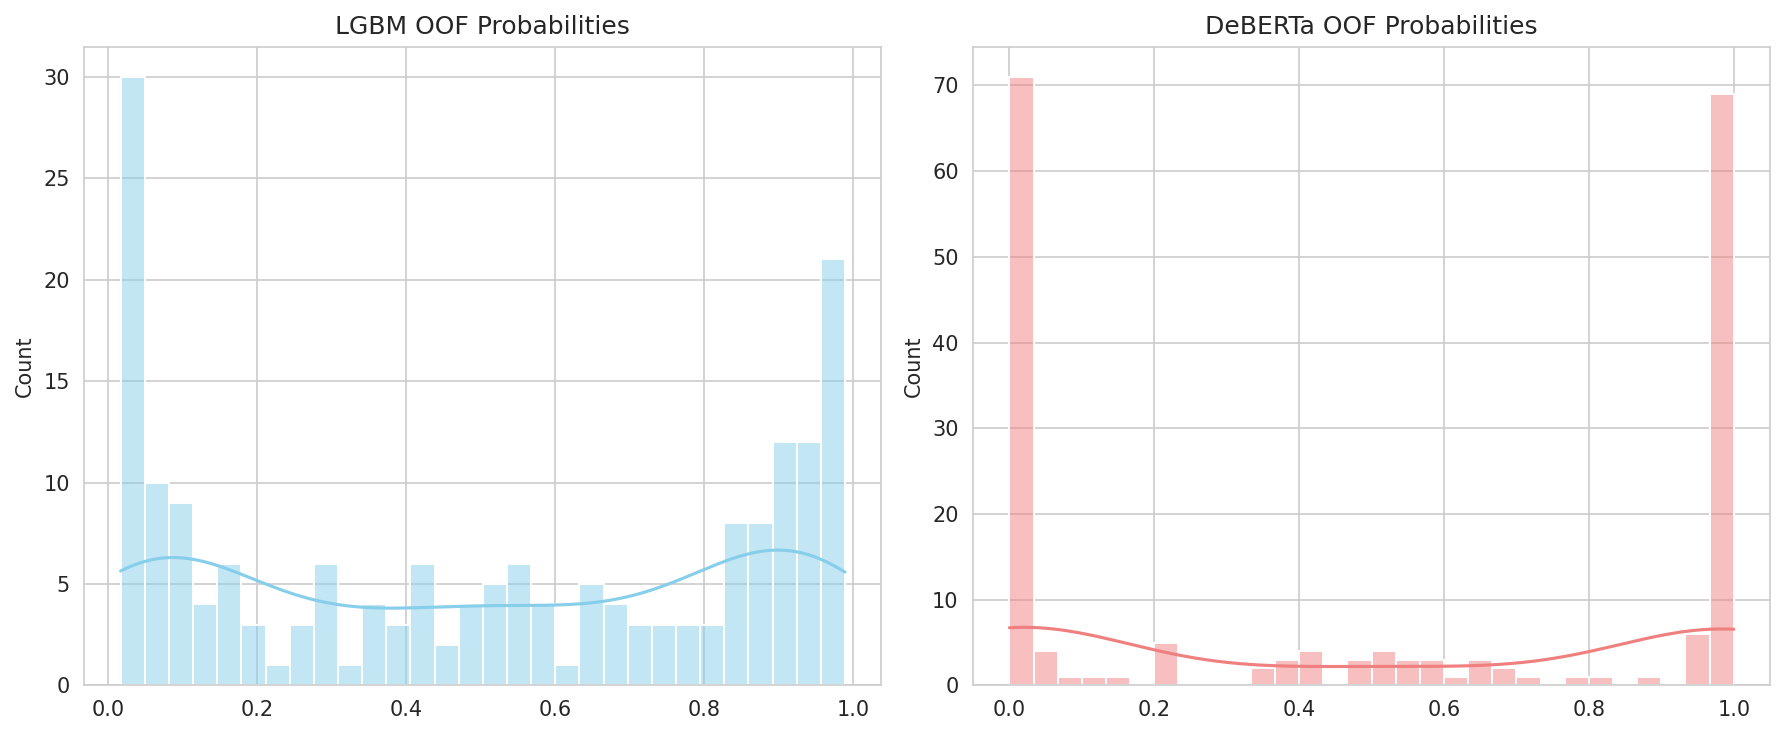

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


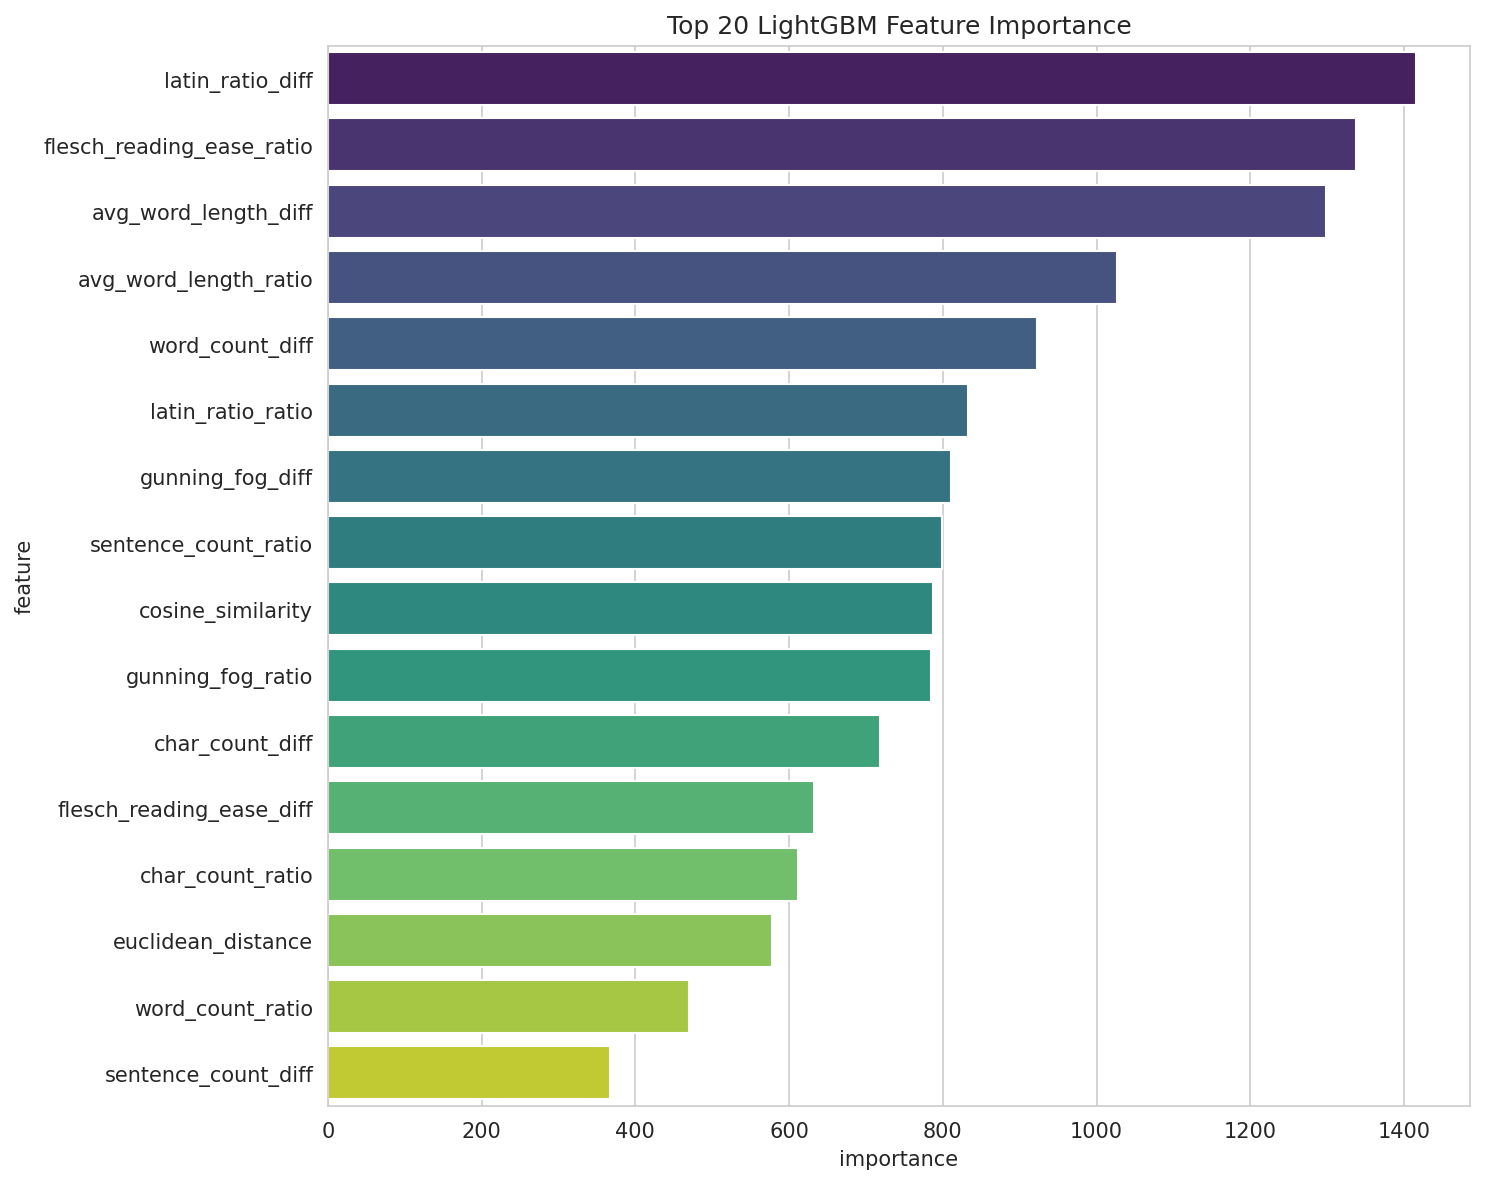

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(oof_lgbm, bins=30, kde=True, color='skyblue')
plt.title("LGBM OOF Probabilities")
plt.subplot(1, 2, 2)
sns.histplot(oof_deberta, bins=30, kde=True, color='lightcoral')
plt.title("DeBERTa OOF Probabilities")
plt.tight_layout()
plt.show()


full_lgbm_model = lgb.LGBMClassifier(**CFG.lgb_params)
full_lgbm_model.fit(train_df_features[feature_cols], train_df_features[CFG.target_col])
feature_importance = pd.DataFrame({'feature': feature_cols, 'importance': full_lgbm_model.feature_importances_}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette="viridis")
plt.title("Top 20 LightGBM Feature Importance")
plt.tight_layout()
plt.show()